In [3]:
# import d2lzh as d2l
import torch
import torchvision
from torch import nn
import os
import numpy as np
from tqdm import tqdm
import cv2  
import matplotlib.pyplot as plt
data_dir = 'data/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
import time

In [6]:
transforms = torchvision.transforms.Compose([
    # 随机变化亮度、对比度和饱和度
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), 
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.Normalize( [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_ori_ds = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transforms)

In [8]:
test_ds = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transforms)

In [9]:
train_ds, valid_ds = torch.utils.data.random_split(train_ori_ds, [900000, 99891])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


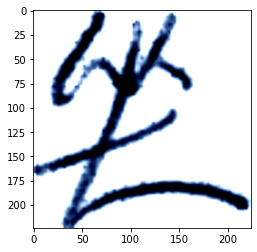

In [10]:
npimg = train_ds[0][0].numpy()
npimg = npimg.transpose(1,2,0)
plt.imshow(npimg)

In [11]:
batch_size = 256

In [12]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, drop_last=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=True)

In [13]:
def get_net(devices, num_class):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet18(pretrained=True)
    # 定义新的输出网络
    # 120是输出的类别个数
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 2048), 
                                           nn.ReLU(), 
                                           nn.Linear(2048, num_class))
    # 把模型参数分配到内存或显存上
    finetune_net = finetune_net.to(devices)
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

In [14]:
loss = nn.CrossEntropyLoss()
def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices), labels.to(devices)
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum = l.sum()
        n += labels.numel()
    return l_sum/n

In [15]:
num_epochs, lr = 50, 0.001
net = get_net(device, len(train_ori_ds.classes))
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [16]:
def train(train_dl, test_dl, net, loss, optimizer, device, num_epochs):
    """
    function：
        训练程序
        
    Parameters:
        train_iter - 训练数据
        test_iter - 测试数据
        net - 网络
        loss - 损失函数
        optimizer - 优化器
        device - 指定计算在GPU或者CPU上进行
        num_epochs - 迭代次数

    Returns:

    Modify:
        2020-12-24
    """
    # 多卡并行
    # print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net = net.cuda()
    # print("training on", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in tqdm(train_dl):
            X = X.to(device)
            y = y.to(device).long()
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1).long()==y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_dl, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec' % (epoch+1, train_l_sum/batch_count, train_acc_sum/n, test_acc, time.time()-start))   

In [17]:
def evaluate_accuracy(data_iter, net, device=None):
    """
    function：
        计算多分类模型预测结果的准确率
        
    Parameters:
        data_iter - 样本划分为最小批的结果
        net - 定义的网络
        device - 指定计算在GPU或者CPU上进行

    Returns:
        准确率计算结果

    Modify:
        2020-11-30
        2020-12-03 增加模型训练模型和推理模式的判别
        2020-12-10 增加指定运行计算位置的方法
    """
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    for X, y in tqdm(data_iter):
        if isinstance(net, torch.nn.Module):
            # 评估模式, 这会关闭dropout
            net.eval()
            # .cpu()保证可以进行数值加减
            acc_sum += (net(X.to(device)).argmax(dim=1).long() == y.to(device).long()).float().sum().cpu().item()
            # 改回训练模式
            net.train()
        # 自定义的模型, 2.13节之后不会用到, 不考虑GPU
        else:
            if ('is_training' in net.__code__.co_varnames):
                # 将is_training设置成False
                acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
            else:
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [18]:
train(train_dl, valid_dl, net, loss, optimizer, device, num_epochs)

  1%|          | 41/3515 [00:21<30:15,  1.91it/s] 


KeyboardInterrupt: 

In [ ]:
torch.rand(10000,1000000).cuda()